### Quora Insincere Questions: Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models.tfidfmodel import TfidfModel
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from pylab import rcParams
import os
os.chdir('/home/roman/Documents/Projects/Quora/data')

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# --------------- Explore data set --------------- #
print("Let's have a look at the data set: \n")
print(train_data.head())
print('\n')
print('Example of 10 regular questions: \n')
regular = train_data[train_data['target']==0][['question_text']]
for i in range(10):
    print(regular.iloc[i, 0])
insincere = train_data[train_data['target']==1][['question_text']]
print('\n Example of 10 insincere questions: \n')
for i in range(10):
    print(insincere.iloc[i, 0])

Let's have a look at the data set: 

                    qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


Example of 10 regular questions: 

How did Quebec nationalists see their province as a nation in the 1960s?
Do you have an adopted dog, how would you encourage people to adopt and not shop?
Why does velocity affect time? Does velocity affect space geometry?
How did Otto von Guericke used the Magdeburg hemispheres?
Can I convert montra helicon D to a mountain bike by just changing the tyres?
Is Gaza slowly becoming Au

Number of training samples: 1306122
Number of test samples: 56370
Number of regular questions: 1225312
Number of insincere questions: 80810
Percentage of insincere questions: 6.19%


Average number of characters per question: 70.68
Min number of characters per question: 1
Max number of characters per question: 1017
Average number of words per question: 12.8
Min number of words per question: 1
Max number of words per question: 122
Average number of characters per word: 5.57


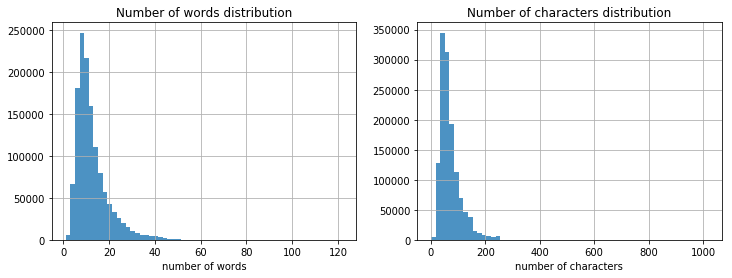

In [4]:
# --------------- Data set stats --------------- #
n_train = train_data.shape[0]
n_test = test_data.shape[0]
perc_insincere_train = round(100 * insincere.shape[0] / train_data.shape[0], 2)
print('Number of training samples: ' + str(n_train))
print('Number of test samples: ' + str(n_test))
print('Number of regular questions: ' + str(regular.shape[0]))
print('Number of insincere questions: ' + str(insincere.shape[0]))
print('Percentage of insincere questions: ' + str(perc_insincere_train) + '%')
print('\n')
n_chars = train_data['question_text'].apply(len)
n_words = train_data['question_text'].str.split(' ').apply(len)
n_chars_per_words = n_chars / n_words
print('Average number of characters per question: ' + str(round(n_chars.mean(), 2)))
print('Min number of characters per question: ' + str(n_chars.min()))
print('Max number of characters per question: ' + str(n_chars.max()))
print('Average number of words per question: ' + str(round(n_words.mean(), 2)))
print('Min number of words per question: ' + str(n_words.min()))
print('Max number of words per question: ' + str(n_words.max()))
print('Average number of characters per word: ' + str(round(n_chars_per_words.mean(), 2)))

rcParams['figure.figsize'] = 12, 4
plt.subplot(1, 2, 1)
plt.hist(n_words, bins=60, alpha=0.8)
plt.grid()
plt.xlabel('number of words')
plt.title('Number of words distribution')
plt.subplot(1, 2, 2)
plt.hist(n_chars, bins=60, alpha=0.8)
plt.grid()
plt.xlabel('number of characters')
plt.title('Number of characters distribution')
plt.show()

The training dataset includes 1.3 million questions (the test set includes 56,370 questions). The training set has 1,225,312 sincere ("regular") and 80,810 insincere questions. This is equal to 6.19% of insincere questions --> we are dealing with a relaively high imbalanced dataset.

Regular questions:
Average number of words per question: 12.51
Min number of words per question: 2
Max number of words per question: 122
Average number of characters per word: 5.56


Insincere questions:
Average number of words per question: 17.28
Min number of words per question: 1
Max number of words per question: 64
Average number of characters per word: 5.69


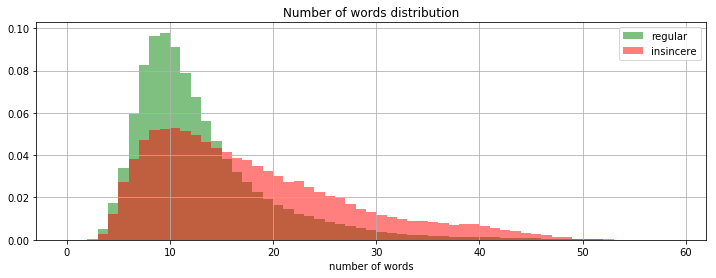

Ks_2sampResult(statistic=0.25726484569731056, pvalue=0.0)


In [5]:
# --------------- Compare stats for regular vs insincere --------------- #
n_chars_reg = regular['question_text'].apply(len)
n_words_reg = regular['question_text'].str.split(' ').apply(len)
n_chars_per_words_reg = n_chars_reg / n_words_reg
n_chars_ins = insincere['question_text'].apply(len)
n_words_ins = insincere['question_text'].str.split(' ').apply(len)
n_chars_per_words_ins = n_chars_ins / n_words_ins

print('Regular questions:')
print('Average number of words per question: ' + str(round(n_words_reg.mean(), 2)))
print('Min number of words per question: ' + str(n_words_reg.min()))
print('Max number of words per question: ' + str(n_words_reg.max()))
print('Average number of characters per word: ' + str(round(n_chars_per_words_reg.mean(), 2)))
print('\n')
print('Insincere questions:')
print('Average number of words per question: ' + str(round(n_words_ins.mean(), 2)))
print('Min number of words per question: ' + str(n_words_ins.min()))
print('Max number of words per question: ' + str(n_words_ins.max()))
print('Average number of characters per word: ' + str(round(n_chars_per_words_ins.mean(), 2)))

bins = np.arange(60)
plt.hist(n_words_reg, bins=bins, alpha=0.5, density=True, color='green')
plt.hist(n_words_ins, bins=bins, alpha=0.5, density=True, color='red')
plt.grid()
plt.xlabel('number of words')
plt.title('Number of words distribution')
plt.legend(['regular', 'insincere'])
plt.show()

print(stats.ks_2samp(n_words_reg, n_words_ins))

The stats above show that insincere questions tend to be longer than regular ones. The Kolmogorov-Smirnov statistic (ks2) confirms the assumption and rejects the null hypothesis that regular and insincere questions are coming from the same distribution (p-value: 0.0)

In [6]:
# --------------- Text analysis - word frequency --------------- #
docs_df = train_data['question_text']
regular_df = regular['question_text']
insincere_df = insincere['question_text']

# remove stopwords words and tokenize:
regular_df = regular_df.apply(remove_stopwords)
insincere_df = insincere_df.apply(remove_stopwords)
regular_list = regular_df.tolist()
insincere_list = insincere_df.tolist()
texts_reg = [[word for word in document.lower().replace("?", "").split()] for document in regular_list]
texts_ins = [[word for word in document.lower().replace("?", "").split()] for document in insincere_list]
texts = texts_reg + texts_ins
# create dict with frequency for all reaminaing words:
frequency_reg, frequency_ins = defaultdict(int), defaultdict(int)
for text in texts_reg:
    for token in text:
        frequency_reg[token] += 1
for text in texts_ins:
    for token in text:
        frequency_ins[token] += 1
frequency_all = {k: frequency_reg.get(k, 0) + frequency_ins.get(k, 0) for k in \
                 set(frequency_reg) | set(frequency_ins) }
most_frequent_all = sorted(frequency_all.items(), key=lambda k_v: k_v[1], reverse=True)
most_frequent_reg = sorted(frequency_reg.items(), key=lambda k_v: k_v[1], reverse=True)
most_frequent_ins = sorted(frequency_ins.items(), key=lambda k_v: k_v[1], reverse=True)
print('The 30 most frequent words from all samples (w/o stopwords) are:')
for tuple_ in most_frequent_all[:30]:
    print(str(tuple_[0]) + ': ' + str(np.round(tuple_[1] / docs_df.shape[0], 4)))
print('\n')
print('The 30 most frequent words from all regular questions are:')
for tuple_ in most_frequent_reg[:30]:
    print(str(tuple_[0]) + ': ' + str(np.round(tuple_[1] / regular_df.shape[0], 4)))
print('\n')
print('The 30 most frequent words from all insincere questions are:')
for tuple_ in most_frequent_ins[:30]:
    print(str(tuple_[0]) + ': ' + str(np.round(tuple_[1] / insincere_df.shape[0], 4)))

The 30 most frequent words from all samples (w/o stopwords) are:
what: 0.3202
i: 0.2347
how: 0.2016
why: 0.1147
is: 0.0845
best: 0.0475
people: 0.0414
can: 0.0405
do: 0.0374
like: 0.0366
which: 0.0363
good: 0.0288
if: 0.0265
india: 0.023
are: 0.0228
think: 0.0198
does: 0.018
who: 0.0169
time: 0.0166
use: 0.0165
life: 0.0157
way: 0.0155
know: 0.0151
where: 0.0148
want: 0.0143
it: 0.0141
work: 0.0138
should: 0.0127
feel: 0.0123
don't: 0.0122


The 30 most frequent words from all regular questions are:
what: 0.3363
i: 0.241
how: 0.2087
why: 0.0952
is: 0.0831
best: 0.0501
can: 0.0418
which: 0.0382
do: 0.0349
like: 0.0343
people: 0.034
good: 0.0296
if: 0.0253
india: 0.0222
are: 0.0205
think: 0.0179
does: 0.0178
who: 0.0173
time: 0.0168
use: 0.0168
life: 0.0161
way: 0.0158
where: 0.0154
know: 0.0148
work: 0.0142
it: 0.0138
want: 0.0133
should: 0.0122
person: 0.0119
feel: 0.0118


The 30 most frequent words from all insincere questions are:
why: 0.4097
people: 0.1522
i: 0.1392
is: 0.1061
how:

There are many words such as 'why', 'what', 'is', 'how', etc. among the 30 most frequent words in both, the regular and the insincere questions. This makes it difficult to compare the most common words for regular vs insincere questions. An interesting detail to notice is that most regular questions appear to start with 'what', while many of the insincere questions appear to start with 'why'. One reason for that could be that insincere questions often make a statement rather than ask an actual question. A question that starts with 'why' might contain a specific statement, such as 'why is ...[statement]...

To better see the difference in most frequent words between regular and incincere questions, we manually filter out the most frequent words that have no meaning: 

In [7]:
# --------------- Word frequency - remove additional stopwords--------------- #
freq_word_list = ['what', 'i', 'how', 'why', 'is', 'can', 'do', 'like','which', \
                  'if', 'are', 'think', 'does', 'who', 'use', 'way', 'know', 'where',\
                  'want', 'it', 'should', 'when', "what's", "don't", "i'm", 'in']
most_frequent_reg_reduced, most_frequent_ins_reduced = [], []
for k, v in most_frequent_reg:
    if k not in freq_word_list:
        most_frequent_reg_reduced.append((k, v))
for k, v in most_frequent_ins:
    if k not in freq_word_list:
        most_frequent_ins_reduced.append((k, v))
print('The 30 most frequent words from all regular questions after reduction are:')
reg_words, reg_word_freq = [], []
for tuple_ in most_frequent_reg_reduced[:30]:
    reg_words.append(tuple_[0])
    reg_word_freq.append(tuple_[1] / regular_df.shape[0])
    print(str(tuple_[0]) + ': ' + str(np.round(tuple_[1] / regular_df.shape[0], 4)))
print('\n')
ins_words, ins_word_freq = [], []
print('The 30 most frequent words from all insincere questions after reduction are:')
for tuple_ in most_frequent_ins_reduced[:30]:
    ins_words.append(tuple_[0])
    ins_word_freq.append(tuple_[1] / insincere_df.shape[0])
    print(str(tuple_[0]) + ': ' + str(np.round(tuple_[1] / insincere_df.shape[0], 4)))
# find frequency of most frequent insincere-question-words in regular questions:
ins_word_freq_reg = []
for word in ins_words:
    ins_word_freq_reg.append(frequency_reg[word] / regular_df.shape[0])
# find frequency of most frequent regular-question-words in insincere questions:
reg_word_freq_ins = []
for word in reg_words:
    reg_word_freq_ins.append(frequency_ins[word] / insincere_df.shape[0])

The 30 most frequent words from all regular questions after reduction are:
best: 0.0501
people: 0.034
good: 0.0296
india: 0.0222
time: 0.0168
life: 0.0161
work: 0.0142
person: 0.0119
feel: 0.0118
better: 0.0112
will: 0.0112
possible: 0.0111
new: 0.011
world: 0.0109
year: 0.0108
job: 0.0108
mean: 0.0103
need: 0.0101
start: 0.01
difference: 0.01
years: 0.0095
different: 0.0094
quora: 0.0094
money: 0.009
learn: 0.009
us: 0.0086
business: 0.0086
long: 0.0085
indian: 0.0083
school: 0.0082


The 30 most frequent words from all insincere questions after reduction are:
people: 0.1522
women: 0.0682
trump: 0.0677
men: 0.0478
white: 0.0433
muslims: 0.0409
quora: 0.0391
indian: 0.0378
india: 0.0359
black: 0.0345
americans: 0.0341
sex: 0.03
indians: 0.0298
girls: 0.0298
hate: 0.0273
world: 0.0268
us: 0.0255
liberals: 0.0249
chinese: 0.0243
muslim: 0.022
american: 0.0208
country: 0.0207
feel: 0.0198
believe: 0.0187
donald: 0.0186
president: 0.0179
true: 0.0178
america: 0.0174
good: 0.017
gay: 0.0165

When comparing the regular to the insincere questions, we recognize some frequent words that appear to be common for insincere questions such as: 'trump', 'white', 'muslims', 'hate', 'sex', 'girls', 'liberals'. It appears that many of the insincere questions target controversial topics such as politics, race and sex. The most frequent words in regular questions are more generic and often appear to be typical for educational purposes (examples: 'possible', 'difference', 'year', 'learn').

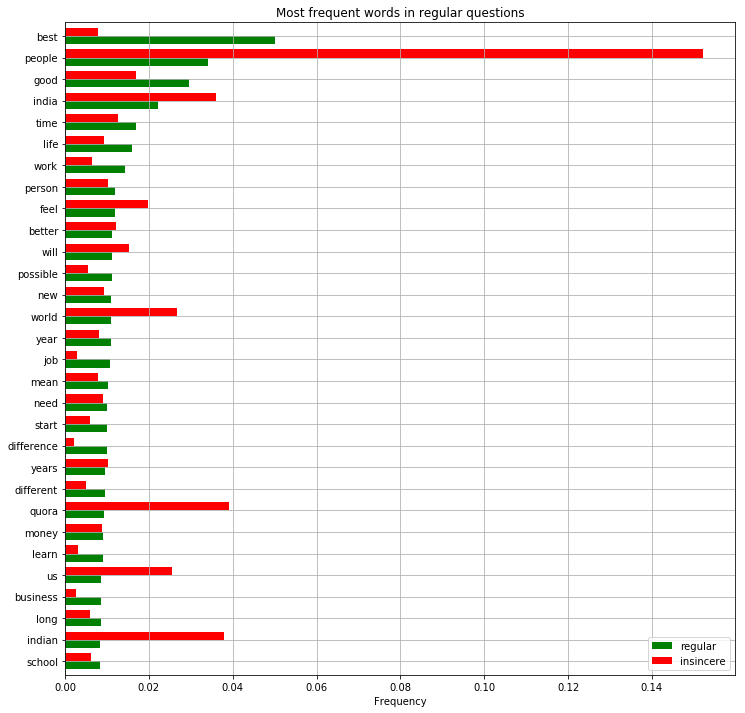

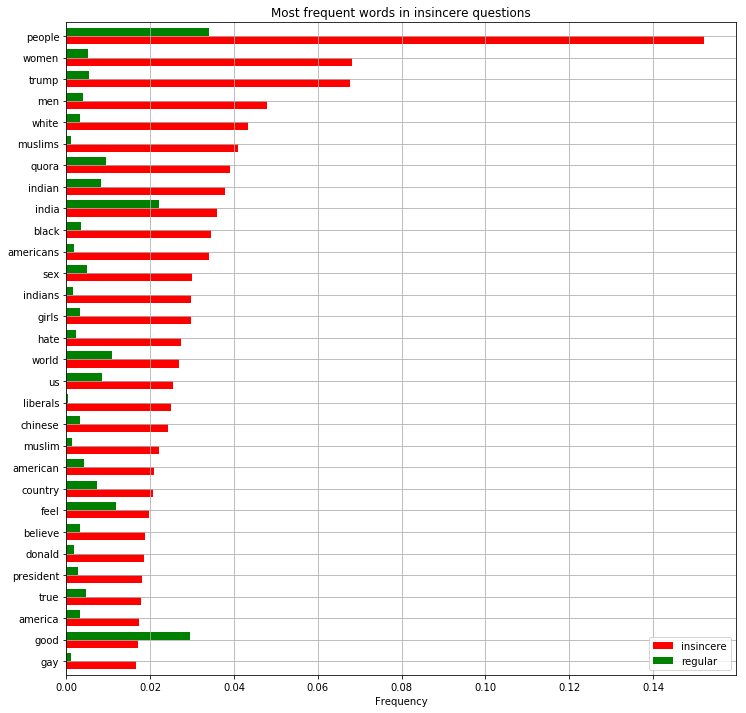

In [8]:
# --------------- Word frequency plots --------------- #
rcParams['figure.figsize'] = 12, 12
df_reg = pd.concat([pd.Series(reg_word_freq), pd.Series(reg_word_freq_ins)], axis=1)
df_reg.index = reg_words
df_reg = df_reg.iloc[::-1]
df_reg.columns = ['regular', 'insincere']
df_reg.plot(kind='barh', stacked=False, width=0.75, color=['green', 'red'])
plt.grid()
plt.title('Most frequent words in regular questions')
plt.xlabel('Frequency')
plt.show()

df_ins = pd.concat([pd.Series(ins_word_freq), pd.Series(ins_word_freq_reg)], axis=1)
df_ins.index = ins_words
df_ins = df_ins.iloc[::-1]
df_ins.columns = ['insincere', 'regular']
df_ins.plot(kind='barh', stacked=False, width=0.75, color=['red', 'green'])
plt.grid()
plt.title('Most frequent words in insincere questions')
plt.xlabel('Frequency')
plt.show()

The first plot compares the frequency of the most frequent words in regular questions to those in insincere questions. The second plot does the same for the most frequent words in insincere questions. A comparison of these plots shows that while the most frequent words in regular questions might also appear frequently in insincere questions, the most frequent words in insincere questions tend to appear much less frequent in regular questions.

'Trump', for example appears in more than 6% of all insincere questions, but appears only in around 0.5% of all regular questions. Words such as 'muslims', 'americans', 'indians', 'liberals' and 'gay' are especially strong indicators for insincere questions.